**Importing Libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import itertools
import re
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt_tab', force=True)
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tutyp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tutyp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tutyp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\tutyp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

**Loading Dataset**    
The dataset was provided in two separate .csv files. The first one contains data needed for training. The second one contains testing data.

In [4]:
train_path = '../data/raw/train.csv'
data_train = pd.read_csv(train_path, sep=',')

test_path  = '../data/raw/test.csv'
data_test  = pd.read_csv(test_path, sep=',')

**Exploratory Data Analysis**  
General statistics about training and testing datasets

In [5]:
def display_dataset_statistics(df):
    df["word_count"] = df["review"].apply(lambda x: len(str(x).split()))
    corpus_size = df["word_count"].sum()
    min_length = df["word_count"].min()
    max_length = df["word_count"].max()
    mean_length = df["word_count"].mean()
    std_length = df["word_count"].std()

    print(f"Number of reviews: ", len(df))
    print(f"Total number of words in the corpus: {corpus_size}")
    print(f"Minimum review length: {min_length} words")
    print(f"Maximum review length: {max_length} words")
    print(f"Mean review length: {mean_length:.2f} words")
    print(f"Standard deviation of review lengths: {std_length:.2f} words")

    print("\nHow many words used on average for negative and for positive review:")
    print(df.groupby("sentiment")["word_count"].mean())

    print("\nFirst 10 reviews:")
    for i, review in enumerate(df["review"].head(10), 1):
        print(f"Review {i}: {review}\n")
    df.drop("word_count", axis=1, inplace=True)

In [6]:
display_dataset_statistics(data_train)

Number of reviews:  40000
Total number of words in the corpus: 9254510
Minimum review length: 4 words
Maximum review length: 2470 words
Mean review length: 231.36 words
Standard deviation of review lengths: 171.08 words

How many words used on average for negative and for positive review:
sentiment
negative    230.18685
positive    232.53865
Name: word_count, dtype: float64

First 10 reviews:
Review 1: I caught this little gem totally by accident back in 1980 or '81. I was at a revival theatre to see two old silly sci-fi movies. The theatre was packed full and (with no warning) they showed a bunch of sci-fi short spoofs (to get us in the mood). Most were somewhat amusing but THIS came on and, within seconds, the audience was in hysterics! The biggest laugh came when they showed "Princess Laia" having huge cinnamon buns instead of hair on her head. She looks at the camera, gives a grim smile and nods. That made it even funnier! You gotta see "Chewabacca" played by what looks like a Mupp

There are 40000 of reviews in training dataset. In total there were used 9254510 words in corpus. The shortest review consists of 4 words. The largest review consists of 2470 words. On average a review in train dataset has 231 words. The standard deviation of reviews lengths in training dataset is 171 words.

Reviews with negative sentiments and with positive sentiments on average have the same number of words in them , around 230 words for both.

In [7]:
display_dataset_statistics(data_test)

Number of reviews:  10000
Total number of words in the corpus: 2303337
Minimum review length: 6 words
Maximum review length: 2108 words
Mean review length: 230.33 words
Standard deviation of review lengths: 172.39 words

How many words used on average for negative and for positive review:
sentiment
negative    226.5754
positive    234.0920
Name: word_count, dtype: float64

First 10 reviews:
Review 1: Yes, MTV there really is a way to market Daria. What started as a clever teenage angst-"comment on everything that sucks and make the viewer feel better about their sucky teenage life" sitcom now mutated into a "how you should deal with your problems"-charade. I used to watch Daria all the time and loved it. Now, sitting here after watching the so called "movie" I can only wonder what the point of this all was. Daria tells us how to lead out life in college? Excuse me? didn't the point Daria made every episode that what you like to do is ok, as long as it is ok with yourself no matter what

There are 10000 of reviews in testing dataset. In total there were used 2303337 words in testing corpus. The shortest review consists of 6 words. The largest review consists of 2108 words. On average a review in test dataset has 230 words(similiar, almost the same value was for training set). The standard deviation of reviews lengths in testing dataset is 172 words(similiar, almost the same value was for training set).

Reviews with negative sentiments and with positive sentiments on average have the same number of words in them , around 230 words for both(same statistic value as for training set).

Main statistics for training and testing sets are very similiar, almost same.

*Distribution of reviews lengths*

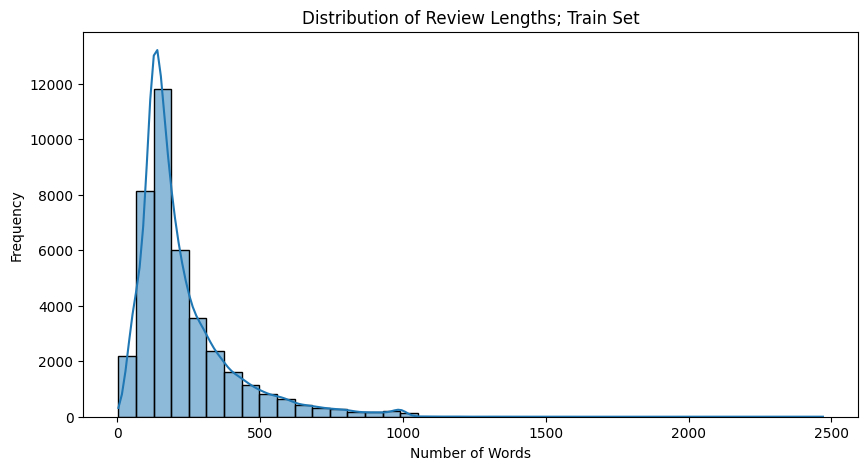

In [8]:
lengths = data_train["review"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(lengths, bins=40, kde=True)
plt.title("Distribution of Review Lengths; Train Set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

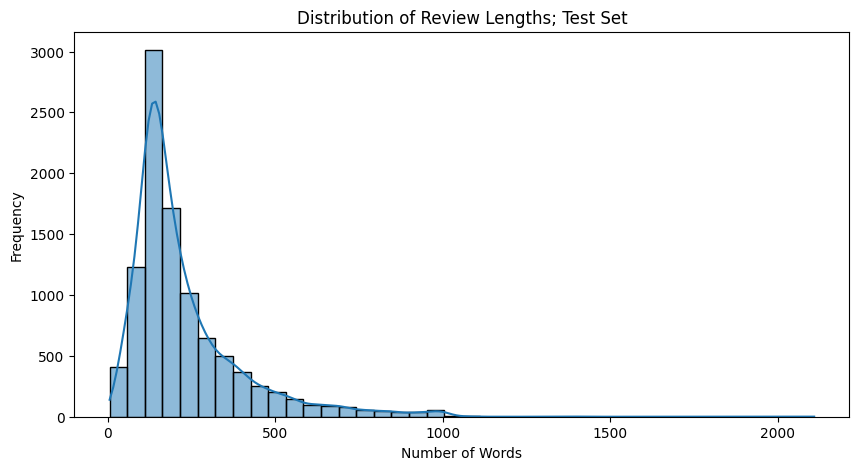

In [9]:
lengths = data_test["review"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(lengths, bins=40, kde=True)
plt.title("Distribution of Review Lengths; Test Set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

Distribution of random variable "Length of review" resembles exponential distribution (same results for training and testing sets).
Reviews of length more than 1000 words could be considered as outliers, unusually large reviews. But for this work such reviews will not be deleted from dataset, as they still might convey very important information during modeling.

*Missing values*

In [10]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


In [11]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


There are no missing values in both training and testing datasets.

*Distribution of sentiment feature*

sentiment
positive    20000
negative    20000
Name: count, dtype: int64


<Axes: title={'center': 'Sentiment Distribution (Train Set)'}, xlabel='sentiment'>

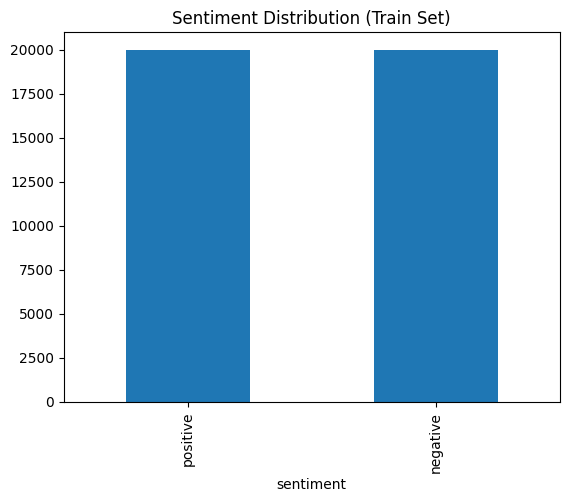

In [12]:
print(data_train["sentiment"].value_counts())
data_train["sentiment"].value_counts().plot(kind="bar", title="Sentiment Distribution (Train Set)")

sentiment
negative    5000
positive    5000
Name: count, dtype: int64


<Axes: title={'center': 'Sentiment Distribution (Test Set)'}, xlabel='sentiment'>

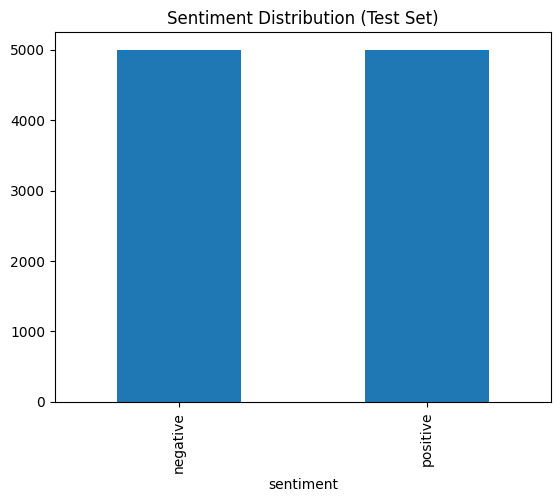

In [13]:
print(data_test["sentiment"].value_counts())
data_test["sentiment"].value_counts().plot(kind="bar", title="Sentiment Distribution (Test Set)")

In both training and testing sets, half of all reviews is marked to have negative sentiment and other half is of positive sentiment. In this sense both datasets are balanced. That also means that accuracy metric could be succesfully used for models perfomance evaluation.

*Most common words in datasets*

In [14]:
word_list = list(itertools.chain(*data_train["review"].apply(lambda x: str(x).split())))
word_counts = Counter(word_list)
print(word_counts.most_common(40))

unique_words = set(word_list)
vocab_size = len(unique_words)
print(f"Vocabulary Size: {vocab_size}")

[('the', 455679), ('a', 245875), ('and', 241774), ('of', 227107), ('to', 209894), ('is', 162303), ('in', 136145), ('I', 106695), ('that', 101613), ('this', 91222), ('it', 86583), ('/><br', 80559), ('was', 74446), ('as', 66557), ('with', 66177), ('for', 65068), ('The', 53844), ('but', 52937), ('on', 48982), ('movie', 48615), ('are', 45306), ('film', 43698), ('his', 43372), ('have', 43230), ('not', 41763), ('you', 40681), ('be', 40506), ('by', 33971), ('at', 33919), ('he', 33687), ('one', 33157), ('an', 32975), ('from', 30307), ('who', 29816), ('like', 28687), ('all', 28267), ('they', 28136), ('so', 25864), ('has', 25829), ('or', 25818)]
Vocabulary Size: 380518


In [15]:
word_list = list(itertools.chain(*data_test["review"].apply(lambda x: str(x).split())))
word_counts = Counter(word_list)
print(word_counts.most_common(40))

unique_words = set(word_list)
vocab_size = len(unique_words)
print(f"Vocabulary Size: {vocab_size}")

[('the', 113056), ('a', 61085), ('and', 60145), ('of', 56518), ('to', 51956), ('is', 40753), ('in', 33836), ('I', 25803), ('that', 25205), ('this', 22504), ('it', 21333), ('/><br', 20415), ('was', 18212), ('as', 16573), ('with', 16392), ('for', 15851), ('The', 13473), ('but', 13345), ('on', 12215), ('movie', 12147), ('are', 11207), ('his', 10826), ('have', 10779), ('film', 10579), ('not', 10377), ('be', 10033), ('you', 10016), ('at', 8502), ('he', 8427), ('by', 8319), ('one', 8177), ('an', 8101), ('from', 7569), ('who', 7391), ('like', 7341), ('they', 7065), ('all', 7005), ('just', 6602), ('has', 6591), ('so', 6522)]
Vocabulary Size: 158916


In both train and test sets most common, popular are in general stop-words. Evidently, they are supposed to be deleted. Can be considered as noise.
Expression "/><br" is also very frequently appearing expression in corpus - also definitely should be deleted. Can be considered as noise.
  
Number of unique tokens used in training corpus(380518 tokens) is twice(approximately) as big as number of unique words used in test corpus(158916 tokens).

*Duplicates*

In [16]:
duplicate_count = data_train.duplicated().sum()
print(f"Number of duplicate reviews in train dataset: {duplicate_count}")

Number of duplicate reviews in train dataset: 272


In [17]:
duplicate_count = data_test.duplicated().sum()
print(f"Number of duplicate reviews in test dataset: {duplicate_count}")

Number of duplicate reviews in test dataset: 13


There are duplicate reviews in training and testing sets. Number of them is very small: for training set is 272 and for testing set is 13. Duplicate reviews should be deleted , so only one stays (out of all duplicates).

*Mutual reviews in test and train sets*

In [18]:
duplicate_reviews = set(data_train["review"]) & set(data_test["review"])
len(duplicate_reviews)

133

There are same, mutual reviews (133) in test and train sets. Such reviews should be deleted from one of the sets.

**Feature engineering and data preparation**

*Dropping duplicates (all kinds of)*  
Will be dropped dublicates that exist separately in test and train sets.  
Mutual reviews (for train and test sets) will be deleted from train set. It is not acceptable for train and test sets to intersect.

In [19]:
data_train = data_train.drop_duplicates()
data_test = data_test.drop_duplicates()

In [20]:
data_train = data_train[~data_train["review"].isin(duplicate_reviews)]

*Deleting unnecessary characters*  
Reviews could contain: URL links, numbers (11, 0, 34, 2005, etc), punctuation and special characters (,^&*;/$) - all such characters/expressions should be deleted from each review. These characters, parts of review texts do not contain information related, helpful for modeling. That is why they are being deleted. Converting all words in each review to lower case will then be applied(so to make text uniform; for example to make words: "Book", "book", "BOOK", "BooK" - represent the same word "book").

In [21]:
def clean_review(review_text):
    review_text = str(review_text)
    review_text = re.sub(r'http\S+', '', review_text)
    review_text = re.sub(r'\d+', '', review_text)
    review_text = re.sub(r'\W+', ' ', review_text)
    review_text = re.sub(r'\s+', ' ', review_text)
    return review_text.lower().strip()

In [22]:
data_train['review'] = data_train['review'].apply(clean_review)
data_test['review'] = data_test['review'].apply(clean_review)

*Tokenization*  
Here will be applied tokenization to every review text - meaning that every review will be divided by words of which it consists. This will make it easier to preprocess text in next steps.

In [23]:
def tokenize_review(review_text):
    return word_tokenize(review_text)

In [24]:
data_train['review'] = data_train['review'].apply(tokenize_review)
data_test['review'] = data_test['review'].apply(tokenize_review)

*Stop-words filtering*  
As was mentioned in EDA part, words (stop-words) like: "the", "a", "is", "they", "me", ... - should be deleted. Because they are ubiquitous across all reviews , do not contain helpful, vital information that could be used during modeling. Such words could be considered as noise.

In [25]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(tokenized_text):
    return [word for word in tokenized_text if word not in stop_words]

In [26]:
data_train['review'] = data_train['review'].apply(remove_stopwords)
data_test['review'] = data_test['review'].apply(remove_stopwords)

*Stemming vs Lemmatization*  
In the project will be tried two techniques: stemming and lemmatization. Then they will be compared (after modeling) in order to discover which of them works better, gives better results (with which of technique models achieve higher accuracy). Brief description of them: these two techniques are used to truncate words, reduce their form to the smallest possible. Use of them would make vocabulary of all reviews much smaller, would reduce feature space, which is beneficial. Stemming is based on deleting ending of a word. Lemmatization is based on finding the smallest original correct lexical form of the word. Lemmatization is much complicated and precise technique.

In [27]:
stemmer = PorterStemmer()
def apply_stemming(tokens):
    return [stemmer.stem(word) for word in tokens]
data_train['StemmatizedReview'] = data_train['review'].apply(apply_stemming)
data_test['StemmatizedReview'] = data_test['review'].apply(apply_stemming)

In [28]:
lemmatizer = WordNetLemmatizer()
def apply_lemmatization(tokens):
    return [lemmatizer.lemmatize(word, wordnet.NOUN) for word in tokens]

data_train['LemmatizedReview'] = data_train['review'].apply(apply_lemmatization)
data_test['LemmatizedReview'] = data_test['review'].apply(apply_lemmatization)

In [29]:
print("Review:            ", " ".join(data_train['review'].iloc[0]))
print("Stemmatized Review:", " ".join(data_train['StemmatizedReview'].iloc[0]))
print("Lemmatized Review: ", " ".join(data_train['LemmatizedReview'].iloc[0]))

Review:             caught little gem totally accident back revival theatre see two old silly sci fi movies theatre packed full warning showed bunch sci fi short spoofs get us mood somewhat amusing came within seconds audience hysterics biggest laugh came showed princess laia huge cinnamon buns instead hair head looks camera gives grim smile nods made even funnier got ta see chewabacca played looks like muppet extremely silly stupid stop laughing dialogue drowned laughter also know star wars pretty well even funnier deliberately poke fun dialogue really works audience definite
Stemmatized Review: caught littl gem total accid back reviv theatr see two old silli sci fi movi theatr pack full warn show bunch sci fi short spoof get us mood somewhat amus came within second audienc hyster biggest laugh came show princess laia huge cinnamon bun instead hair head look camera give grim smile nod made even funnier got ta see chewabacca play look like muppet extrem silli stupid stop laugh dialogu 

Can be noticed that stemming gives very rough results, for example it transforms words: accident -> accid; revival -> reviv; theatre -> theatr; movies -> movi; amusing -> amus. Which are not properly spelled english words, basically it comes up with short, unmeaningfull words.  

From other side, we get almost perfect truncation of words after applying lemmatization, words are correctly transformed to their shortest forms. Though, sometimes, technique might not shorten word when it is applicable, possible.

*Short Tokens Deletion*  
Now, let's clean vocabulary of corpus even more. We need do delete symbol "br", which was postulated in EDA. Overall, we do not need any words of length <= 2, most likely they do not explain anything. So, let's delete them.

In [30]:
def remove_short_words(tokens):
    return [word for word in tokens if len(word) > 2]

data_train["LemmatizedReview"] = data_train["LemmatizedReview"].apply(remove_short_words)
data_test["LemmatizedReview"] = data_test["LemmatizedReview"].apply(remove_short_words)

data_train["StemmatizedReview"] = data_train["StemmatizedReview"].apply(remove_short_words)
data_test["StemmatizedReview"] = data_test["StemmatizedReview"].apply(remove_short_words)

**EDA: PART 2**  
Now, can be investigated most popular, important words/phrases again, as the dataset have been cleaned.

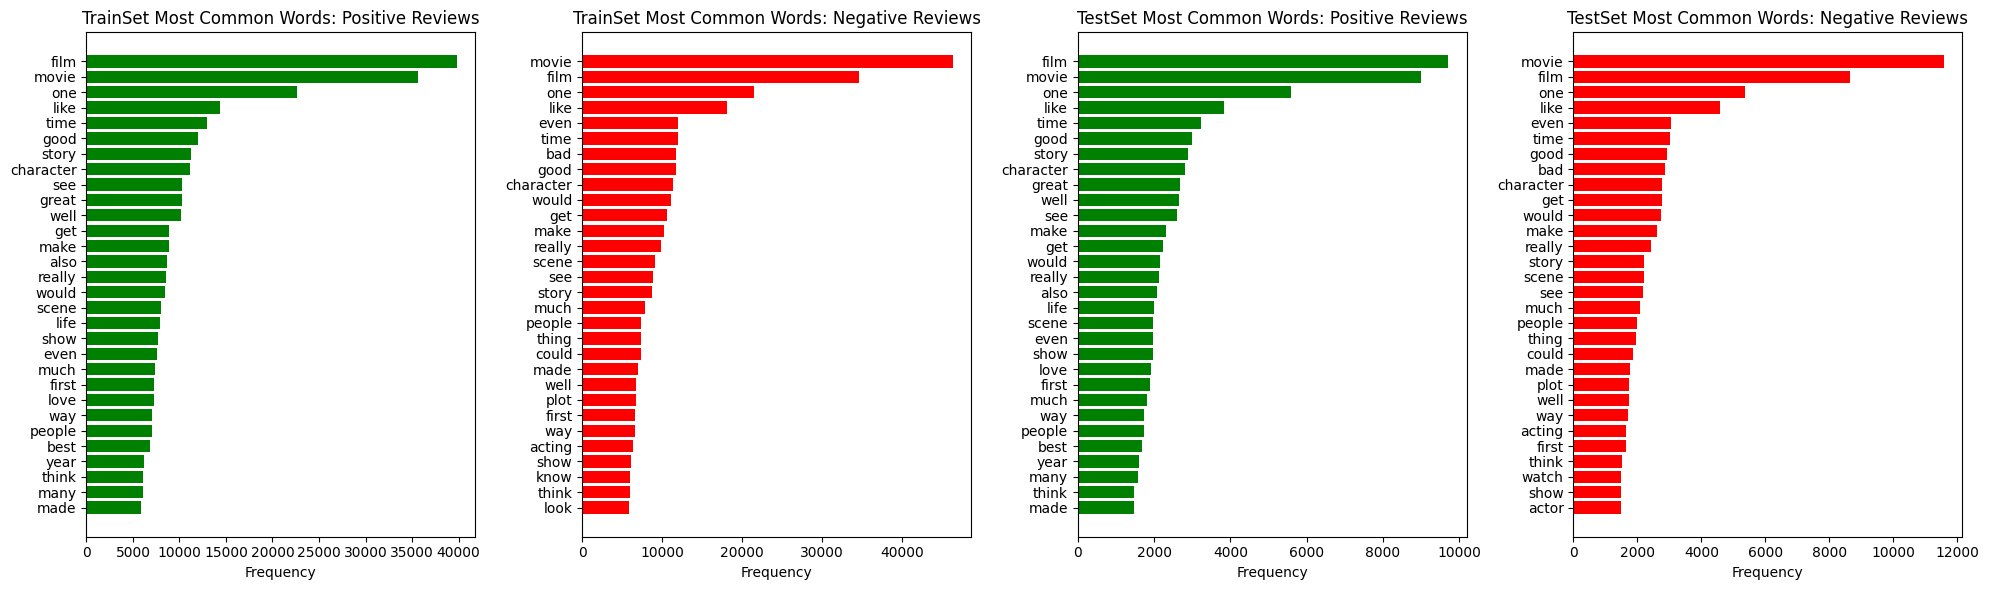

In [117]:
def get_most_common_words(tokenized_texts):
    word_list = [word for words in tokenized_texts for word in words]
    word_counts = Counter(word_list).most_common(30)
    return word_counts

#training set most common words
pos_words = get_most_common_words(data_train[data_train["sentiment"] == "positive"]["LemmatizedReview"])
neg_words = get_most_common_words(data_train[data_train["sentiment"] == "negative"]["LemmatizedReview"])

pos_words, pos_counts = zip(*pos_words)
neg_words, neg_counts = zip(*neg_words)

#testing set most common words
pos_words_test = get_most_common_words(data_test[data_test["sentiment"] == "positive"]["LemmatizedReview"])
neg_words_test = get_most_common_words(data_test[data_test["sentiment"] == "negative"]["LemmatizedReview"])

pos_words_test, pos_counts_test = zip(*pos_words_test)
neg_words_test, neg_counts_test = zip(*neg_words_test)

plt.figure(figsize=(20,6))  

gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1]) 

plt.subplot(gs[0, 0])  
plt.barh(pos_words, pos_counts, color="green")
plt.title("TrainSet Most Common Words: Positive Reviews")
plt.xlabel("Frequency")
plt.gca().invert_yaxis()

plt.subplot(gs[0, 1])  
plt.barh(neg_words, neg_counts, color="red")
plt.title("TrainSet Most Common Words: Negative Reviews")
plt.xlabel("Frequency")
plt.gca().invert_yaxis()

plt.subplot(gs[0, 2])  
plt.barh(pos_words_test, pos_counts_test, color="green")
plt.title("TestSet Most Common Words: Positive Reviews")
plt.xlabel("Frequency")
plt.gca().invert_yaxis()

plt.subplot(gs[0, 3])  
plt.barh(neg_words_test, neg_counts_test, color="red")
plt.title("TestSet Most Common Words: Negative Reviews")
plt.xlabel("Frequency")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

TRAIN SET.   
Most popular words for negative and positive reviews are in general the same. Exceptions are words "bad" - only distinctive popular word for negative reviews and "great",   "love", "first" only distinctive popular words of positive reviews.  
TEST SET.   
The same situation, most popular words are the same for positive and negative reviews, though there are some exceptions:  
distinctive words of positive reviews: "great", "love", "first'; distinctive words of negative reviews: "bad".

Train and test sets have common most popular words, so can be very roughly said that these sets are coming from the same distribution, the training sets corresponds to testing(or in other side).
 

In [118]:
def get_most_common_2grams(texts, n=30):
    texts = [" ".join(words) for words in texts]
    vectorizer = CountVectorizer(ngram_range=(2,2))
    X = vectorizer.fit_transform(texts)
    
    word_counts = np.array(X.sum(axis=0)).flatten()
    vocab = vectorizer.get_feature_names_out()
    
    ngram_counts = Counter(dict(zip(vocab, word_counts))).most_common(n)
    return ngram_counts

pos_bigrams = get_most_common_2grams(data_train[data_train["sentiment"] == "positive"]["LemmatizedReview"])
neg_bigrams = get_most_common_2grams(data_train[data_train["sentiment"] == "negative"]["LemmatizedReview"])

print("TrainSet Most common bigrams in positive reviews:", pos_bigrams)
print("TrainSet Most common bigrams in negative reviews:", neg_bigrams)

TrainSet Most common bigrams in positive reviews: [('one best', 1355), ('even though', 854), ('year old', 849), ('ever seen', 787), ('first time', 761), ('new york', 686), ('main character', 677), ('good movie', 653), ('special effect', 649), ('see movie', 644), ('must see', 635), ('year ago', 629), ('great movie', 616), ('movie like', 612), ('real life', 600), ('look like', 598), ('well done', 558), ('film like', 550), ('movie ever', 527), ('horror film', 525), ('watch movie', 506), ('great film', 498), ('see film', 490), ('year later', 486), ('love story', 479), ('low budget', 477), ('movie one', 470), ('film one', 467), ('pretty good', 458), ('really good', 452)]
TrainSet Most common bigrams in negative reviews: [('look like', 1748), ('ever seen', 1371), ('special effect', 1197), ('waste time', 1135), ('movie ever', 1064), ('year old', 1029), ('bad movie', 1019), ('low budget', 988), ('worst movie', 913), ('horror movie', 873), ('main character', 872), ('movie like', 838), ('much be

Distinctive pairs of words for positive reviews(TRAIN SET): "one best", "highly recommend", "great movie", "must see", "great film", "like movie", "love movie";  
Distinctive pairs of words for negative reviews(TRAIN SET): "bad movie", "waste time", "low budget", "bad film", "one bad", "horror movie", "movie bad", "bad act", "horror film", "bad guy";  

Can be noticed that popular two words phrases for positive reviews contain positive words, express positive emotions. Opposite fact holds for popular phrases of negative reviews. That was expectable.  

Such pairs seems to be reasonable factors at separating positive review from negative.

In [119]:
pos_bigrams = get_most_common_2grams(data_test[data_test["sentiment"] == "positive"]["LemmatizedReview"])
neg_bigrams = get_most_common_2grams(data_test[data_test["sentiment"] == "negative"]["LemmatizedReview"])

print("TestSet Most common bigrams in positive reviews:", pos_bigrams)
print("TestSet Most common bigrams in negative reviews:", neg_bigrams)

TestSet Most common bigrams in positive reviews: [('one best', 326), ('even though', 236), ('year old', 231), ('first time', 204), ('ever seen', 184), ('special effect', 181), ('see movie', 177), ('new york', 168), ('well done', 168), ('real life', 163), ('movie like', 161), ('great movie', 160), ('main character', 155), ('good movie', 153), ('movie one', 151), ('must see', 150), ('year ago', 142), ('film like', 140), ('look like', 138), ('great film', 134), ('saw movie', 133), ('high school', 130), ('film one', 126), ('watch movie', 126), ('low budget', 122), ('pretty good', 122), ('take place', 122), ('year later', 118), ('movie ever', 117), ('horror film', 114)]
TestSet Most common bigrams in negative reviews: [('look like', 412), ('ever seen', 355), ('waste time', 298), ('special effect', 285), ('movie ever', 265), ('year old', 252), ('bad movie', 249), ('low budget', 246), ('movie like', 217), ('worst movie', 209), ('one worst', 203), ('main character', 200), ('horror movie', 198)

Distinctive pairs of words for positive reviews(TEST SET): "one best", "highly recommend", "great movie", "must see", "great film", "movie one", "like movie", "love movie";  
Distinctive pairs of words for negative reviews(TEST SET): "bad movie", "waste time", "low budget", "one bad", "bad film", "horror movie", "movie bad", "horror film", "bad guy";

Overall, test and train sets have common most popular two words phrases for negative and positive reviews. That again proves that both sets are related, are coming from the same distribution.

**Feature engineering and data preparation: CONTINUATION**  
*Vectorization*

Two different techniques for vectorization  will be used: Count Vectorizer and TF-IDF. After training models, the best vectorization technique will be chosen. Difference between Count Vectorizer and TF-IDF:    
- Count Vectorizer is a technique of converting text to vector, that relies solely on counting frequencies of each word appearing in peace of text(in short);  
- TF-IDF Vectorizer still converts text to vector, but it not only counts word frequency in text, but also reduces importance of words that are too common across the whole corpus. It is more sophisticated technique of text vectorization(comparing to previous one). It is expected for it to give better results during modeling, as it conveys more information to model, comparing to Count Vectorizer.

In [31]:
count_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=5000)
X_train_stem_count = count_vectorizer.fit_transform(data_train["StemmatizedReview"].apply(lambda x: " ".join(x)))
X_test_stem_count = count_vectorizer.transform(data_test["StemmatizedReview"].apply(lambda x: " ".join(x)))

In [32]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X_train_stem_tfidf = tfidf_vectorizer.fit_transform(data_train["StemmatizedReview"].apply(lambda x: " ".join(x)))
X_test_stem_tfidf = tfidf_vectorizer.transform(data_test["StemmatizedReview"].apply(lambda x: " ".join(x)))

In [33]:
X_train_lemma_count = count_vectorizer.fit_transform(data_train["LemmatizedReview"].apply(lambda x: " ".join(x)))
X_test_lemma_count = count_vectorizer.transform(data_test["LemmatizedReview"].apply(lambda x: " ".join(x)))

In [34]:
X_train_lemma_tfidf = tfidf_vectorizer.fit_transform(data_train["LemmatizedReview"].apply(lambda x: " ".join(x)))
X_test_lemmma_tfidf = tfidf_vectorizer.transform(data_test["LemmatizedReview"].apply(lambda x: " ".join(x)))

*Preparing target variable*  
Firstly, target feature will be extracted from train and test datasets. After that its values will mapped with this rule:  "positive" -> 1 and "negative" -> 0.

In [35]:
y_train = data_train["sentiment"].map({"positive": 1, "negative": 0})
y_test = data_test["sentiment"].map({"positive": 1, "negative": 0})

**Modeling**

*Defining model functions*

In [125]:
def NaiveBayes(X_train, X_test, y_train, y_test):
    nb_model = ComplementNB()

    nb_model.fit(X_train, y_train)

    y_pred_nb = nb_model.predict(X_test)

    accuracy_nb = accuracy_score(y_test, y_pred_nb)
    print(f"Naive Bayes Accuracy: {accuracy_nb:.4f}")

In [126]:
def LogRegression(X_train, X_test, y_train, y_test):
    lr_model = LogisticRegression(max_iter=500, solver="liblinear")

    lr_model.fit(X_train, y_train)

    y_pred_lr = lr_model.predict(X_test)

    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")

In [127]:
def RandomForest(X_train, X_test, y_train, y_test):
    rf_model = RandomForestClassifier(n_estimators=500, max_depth=50, random_state=1)

    rf_model.fit(X_train, y_train)

    y_pred_rf = rf_model.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

In [128]:
def XGBoost(X_train, X_test, y_train, y_test):
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",max_depth=10,learning_rate=0.05,n_estimators=500)

    xgb_model.fit(X_train, y_train)

    y_pred_xgb = xgb_model.predict(X_test)

    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
    print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")

**Modeling (Stemming; Count Vectorizer)**

In [129]:
NaiveBayes(X_train_stem_count, X_test_stem_count, y_train, y_test)

Naive Bayes Accuracy: 0.8522


In [130]:
LogRegression(X_train_stem_count, X_test_stem_count, y_train, y_test)

Logistic Regression Accuracy: 0.8707


In [131]:
RandomForest(X_train_stem_count, X_test_stem_count, y_train, y_test)

Random Forest Accuracy: 0.8529


In [132]:
XGBoost(X_train_stem_count, X_test_stem_count, y_train, y_test)

XGBoost Accuracy: 0.8652


**Modeling (Lemmatization; Count Vectorizer)**

In [133]:
NaiveBayes(X_train_lemma_count, X_test_lemma_count, y_train, y_test)

Naive Bayes Accuracy: 0.8564


In [134]:
LogRegression(X_train_lemma_count, X_test_lemma_count, y_train, y_test)

Logistic Regression Accuracy: 0.8747


In [135]:
RandomForest(X_train_lemma_count, X_test_lemma_count, y_train, y_test)

Random Forest Accuracy: 0.8547


In [136]:
XGBoost(X_train_lemma_count, X_test_lemma_count, y_train, y_test)

XGBoost Accuracy: 0.8677


**Modeling (Stemming; TF-IDF Vectorization)**

In [137]:
NaiveBayes(X_train_stem_tfidf, X_test_stem_tfidf, y_train, y_test)

Naive Bayes Accuracy: 0.8547


In [138]:
LogRegression(X_train_stem_tfidf, X_test_stem_tfidf, y_train, y_test)

Logistic Regression Accuracy: 0.8884


In [139]:
RandomForest(X_train_stem_tfidf, X_test_stem_tfidf, y_train, y_test)

Random Forest Accuracy: 0.8520


In [140]:
XGBoost(X_train_stem_tfidf, X_test_stem_tfidf, y_train, y_test)

XGBoost Accuracy: 0.8631


**Modeling (Lemmatization; TF-IDF Vectorization)**

In [141]:
NaiveBayes(X_train_lemma_tfidf, X_test_lemmma_tfidf, y_train, y_test)

Naive Bayes Accuracy: 0.8611


In [142]:
LogRegression(X_train_lemma_tfidf, X_test_lemmma_tfidf, y_train, y_test)

Logistic Regression Accuracy: 0.8919


In [143]:
RandomForest(X_train_lemma_tfidf, X_test_lemmma_tfidf, y_train, y_test)

Random Forest Accuracy: 0.8533


In [144]:
XGBoost(X_train_lemma_tfidf, X_test_lemmma_tfidf, y_train, y_test)

XGBoost Accuracy: 0.8656


*Hyperparameters tuning for Logistic Regression with TD-IDF vectorization*

In [145]:
param_grid = {
    'C': np.logspace(-3, 3, 10),  
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

log_reg = LogisticRegression(max_iter=1000)

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_lemma_tfidf, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Training Accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_lemmma_tfidf)

print("Test Accuracy:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': 2.154434690031882, 'penalty': 'l2', 'solver': 'liblinear'}
Best Training Accuracy: 0.8874100265184998
Test Accuracy: 0.893060979273055


*Conclusions*

Models that were using lemmatized dataset were slightly better than those that were trained on stemmatized data. Though mostly the diference in perfomance is very small, could be considered insignificant.

Naive Bayes and Logistic Regression models that were trained on data vectorized with TF-IDF technique showed slightly higher accuracy scores(compared to same type models trained on vectorized data with Count technique). The opposite holds for Random Forest Clasifiers and XGBoost Classifiers(which had higher accuracy scores with data vectorized using Count technique), though in this case the differences is very small, again can be considered insignificant.

Overall, all models(Naive Bayes, Logistic Regression, Random Forest Classifier and XGBoost Classifier) regarded (in this project, notebook) have shown accuracy equal to or higher than 85%.

Naive Bayes and Logistic Regression that were trained on lemmatized, tf-idf vectorized dataset had the highest accuracy scores(86% and 89% respectfully) among same type of models. 

Random Forest Classifier and XGBoost Classifier that were trained on lemmatized dataset vectorized with count technique had the highest accuracy scores(85% and 86% respectfully) among same type of models.

Afterall, the best model was Logistic Regression trained on lemmatized, tf-idf vectorized dataset with accuracy 89%. To achieve this reuslt was also applied hyperparameters tuning(found optimal hyperparameters: C=2.15; penalty=l2; solver=liblinear). (Meaning of hyperparameters: C - specifies regularization strength; penalty - specifies regularization type; solver - specifies the algorithm that is used during optimization(for such high dimensional datasets , as in our case, it is recommended to choose: liblinear or saga))  

**Potential business applications and value for business**

Sentiment analysis, for example, could help in:   
- unraveling general attitude of customers towards comany's particular product, its new feature, etc. That could help to determine, adjust tactic of product development;  
- identifying customer demandings, needs;
- pointing the company whether direction of its development was chosen correctly;

In this specific case, a film streaming service could analyze users comments towards each particular film and make predictions whether to suggest this film to a bigger audience or not. Or, a filmmaking company could analyze commentings of produced films and gather, develop some knowledge what upcoming films should contain in order to be liked by viewers.